<a href="https://colab.research.google.com/github/VintageGold/Text_Summarization/blob/main/Topic_modeling_LDA_and_tsne_for_TMH_liang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
import json
import pandas as pd
import string
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from  vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Mounted at /content/gdrive


In [ ]:
df_metadata = pd.read_csv('/content/gdrive/My Drive/Text_Summarization/Telehealth_article.csv')

In [ ]:
def clean_text(text,lowercase=True):
    
    corpus =  text
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans("","",string.punctuation + "\n" + "\tb")
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return ' '.join(remove_extra_whitespaces)

In [ ]:
df_metadata['Content_Clean'] = df_metadata['Content'].apply(lambda text: clean_text(text))
df_metadata['Content_Length'] = df_metadata['Content_Clean'].apply(lambda text: len(text))
df_metadata['Abstract_Length'] = df_metadata['Abstract'].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split(" ")[1:])
df_metadata['Parsed_Keywords_Length'] = df_metadata['Parsed_Keywords'].apply(lambda text: len(text))

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Text_Summarization/Telehealth_article_1.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Index,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Clean,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length
0,0,0,1,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,veterans face a variety of stressors related t...,35996,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5
1,1,1,2,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,the impact of the covid19 pandemic on the chil...,71152,1577,"['remote', 'child', 'custody', 'evaluations,',...",10
2,2,2,3,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",in novemer 2019 covid19—the infectious highly ...,60855,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8
3,3,3,4,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,anxiety and depressive disorders are among the...,29089,1650,"['education', 'and', 'training,', 'telepsychol...",6
4,4,4,5,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",in midmarch 2020 the authors—as well as the ma...,40983,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6


In [ ]:
import sys
!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 
# Convert to list
data = df.Content_Clean.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['veterans', 'face', 'variety', 'of', 'stressors', 'related', 'to', 'their', 'military', 'service', 'institute', 'of', 'medicine', 'tanielian', 'et', 'al', 'most', 'veterans', 'who', 'return', 'from', 'military', 'conflict', 'do', 'not', 'have', 'mental', 'health', 'condition', 'ut', 'all', 'veterans', 'experience', 'period', 'of', 'readjustment', 'as', 'they', 'reintegrate', 'into', 'life', 'with', 'family', 'friends', 'and', 'community', 'sustance', 'ause', 'and', 'mental', 'health', 'services', 'administration', 'samhsa', 'tanielian', 'et', 'al', 'those', 'individuals', 'must', 'juggle', 'variety', 'of', 'sometimes', 'conflicting', 'family', 'and', 'militaryrelated', 'responsiilities', 'learn', 'to', 'readjust', 'to', 'environments', 'where', 'ehaviors', 'associated', 'with', 'constant', 'state', 'of', 'readiness', 'are', 'no', 'longer', 'needed', 'and', 'process', 'comatrelated', 'exposure', 'that', 'may', 'collectively', 'contriute', 'to', 'prolems', 'for', 'oth', 'veterans', 'an

### Build the Bigram, Trigram Models and Lemmatize

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### Build the Topic Model

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.015*"treatment" + 0.013*"intervention" + 0.013*"health" + 0.011*"family" '
  '+ 0.010*"provider" + 0.008*"client" + 0.007*"care" + 0.007*"technology" + '
  '0.006*"provide" + 0.006*"include"'),
 (1,
  '0.022*"client" + 0.020*"psychologist" + 0.014*"practice" + 0.011*"service" '
  '+ 0.010*"technology" + 0.010*"tmht" + 0.009*"privacy" + 0.009*"program" + '
  '0.008*"information" + 0.007*"ethical"'),
 (2,
  '0.039*"care" + 0.037*"health" + 0.024*"veteran" + 0.021*"mental" + '
  '0.014*"community" + 0.014*"patient" + 0.010*"model" + 0.009*"service" + '
  '0.008*"tow" + 0.008*"rural"'),
 (3,
  '0.016*"telepsychology" + 0.011*"treatment" + 0.010*"service" + '
  '0.010*"provide" + 0.009*"training" + 0.009*"veteran" + 0.009*"study" + '
  '0.007*"psychologist" + 0.007*"clinic" + 0.006*"clinical"')]


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.030*"treatment" + 0.023*"intervention" + 0.018*"family" + 0.012*"child" + '
  '0.011*"couple" + 0.011*"health" + 0.011*"therapist" + 0.009*"provider" + '
  '0.008*"client" + 0.008*"participant"'),
 (1,
  '0.058*"ipcit" + 0.026*"score" + 0.022*"skill" + 0.017*"farmer" + '
  '0.017*"parent" + 0.015*"training" + 0.013*"rate" + 0.012*"live" + '
  '0.011*"model" + 0.011*"clinicased_pcit"'),
 (2,
  '0.029*"test" + 0.023*"administration" + 0.023*"forensic" + 0.014*"score" + '
  '0.014*"remote" + 0.011*"proctor" + 0.009*"emental" + 0.008*"evaluation" + '
  '0.007*"administer" + 0.007*"examinee"'),
 (3,
  '0.015*"service" + 0.012*"practice" + 0.012*"psychologist" + 0.012*"provide" '
  '+ 0.011*"client" + 0.010*"training" + 0.009*"technology" + 0.009*"program" '
  '+ 0.009*"telepsychology" + 0.007*"health"'),
 (4,
  '0.040*"tmht" + 0.036*"client" + 0.029*"privacy" + 0.025*"psychologist" + '
  '0.022*"confidentiality" + 0.019*"protect" + 0.017*"apa" + 0.017*"provider" '
  '+ 0.014*"datu

### What is the Dominant topic and its percentage contribution in each document

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9588,"telepsychology, treatment, service, provide, training, veteran, study, psychologist, clinic, cli...","[veteran, face, variety, stressor, relate, institute, medicine, return, military, conflict, ment..."
1,1,0.0,0.8726,"treatment, intervention, health, family, provider, client, care, technology, provide, include","[impact, child_custody, evaluation, cce, community, een, astounding, immediate, state, local, go..."
2,2,0.0,0.3725,"treatment, intervention, health, family, provider, client, care, technology, provide, include","[infectious, highly, communicale, potentially, fatal, disease, cause, novel, originate, month, d..."
3,3,3.0,0.9176,"telepsychology, treatment, service, provide, training, veteran, study, psychologist, clinic, cli...","[anxiety, depressive, disorder, common, impair, mental, illness, emerge, research, suggest, covi..."
4,4,0.0,0.9151,"treatment, intervention, health, family, provider, client, care, technology, provide, include","[author, majority, therapist, advise, work, home, office, help, stop, spread, covid, thus, egan,..."
5,5,3.0,0.9881,"telepsychology, treatment, service, provide, training, veteran, study, psychologist, clinic, cli...","[early, health, authority, notify, type, identify, cause, outreak, respiratory, infection, nearl..."
6,6,3.0,0.8699,"telepsychology, treatment, service, provide, training, veteran, study, psychologist, clinic, cli...","[million, people, diagnosale, mental, disorder, adequate, access, train, mental, health, profess..."
7,7,0.0,0.8706,"treatment, intervention, health, family, provider, client, care, technology, provide, include","[primary, focus, impact, physical, health, however, pandemic, multisystem, impact, live, canadia..."
8,8,3.0,0.9996,"telepsychology, treatment, service, provide, training, veteran, study, psychologist, clinic, cli...","[worldwide, gap, etween, mental, health, child, adolescent, receive, treatment, kiele, elfer, ki..."
9,9,0.0,0.8713,"treatment, intervention, health, family, provider, client, care, technology, provide, include","[time, write, introduction, covid, infect, million, kill, hundred, thousand, expect, first, mult..."


### The most representative sentence for each topic

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9976,"treatment, intervention, health, family, provider, client, care, technology, provide, include","[couple, family, experience, relationship, family, distress, alarm, rate, third, couple, report,..."
1,1.0,0.9997,"client, psychologist, practice, service, technology, tmht, privacy, program, information, ethical","[aility, search, develop, idea, communicate, securely, way, explore, asic, aspect, identity, gen..."
2,2.0,0.7834,"care, health, veteran, mental, community, patient, model, service, tow, rural","[memer, veteran, act, ravely, sustantial, sacrifice, course, history, high, service, relative, r..."
3,3.0,0.9996,"telepsychology, treatment, service, provide, training, veteran, study, psychologist, clinic, cli...","[worldwide, gap, etween, mental, health, child, adolescent, receive, treatment, kiele, elfer, ki..."


### Frequency Distribution of Word Counts in Documents

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,7), dpi=150)
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,5000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
plt.show()

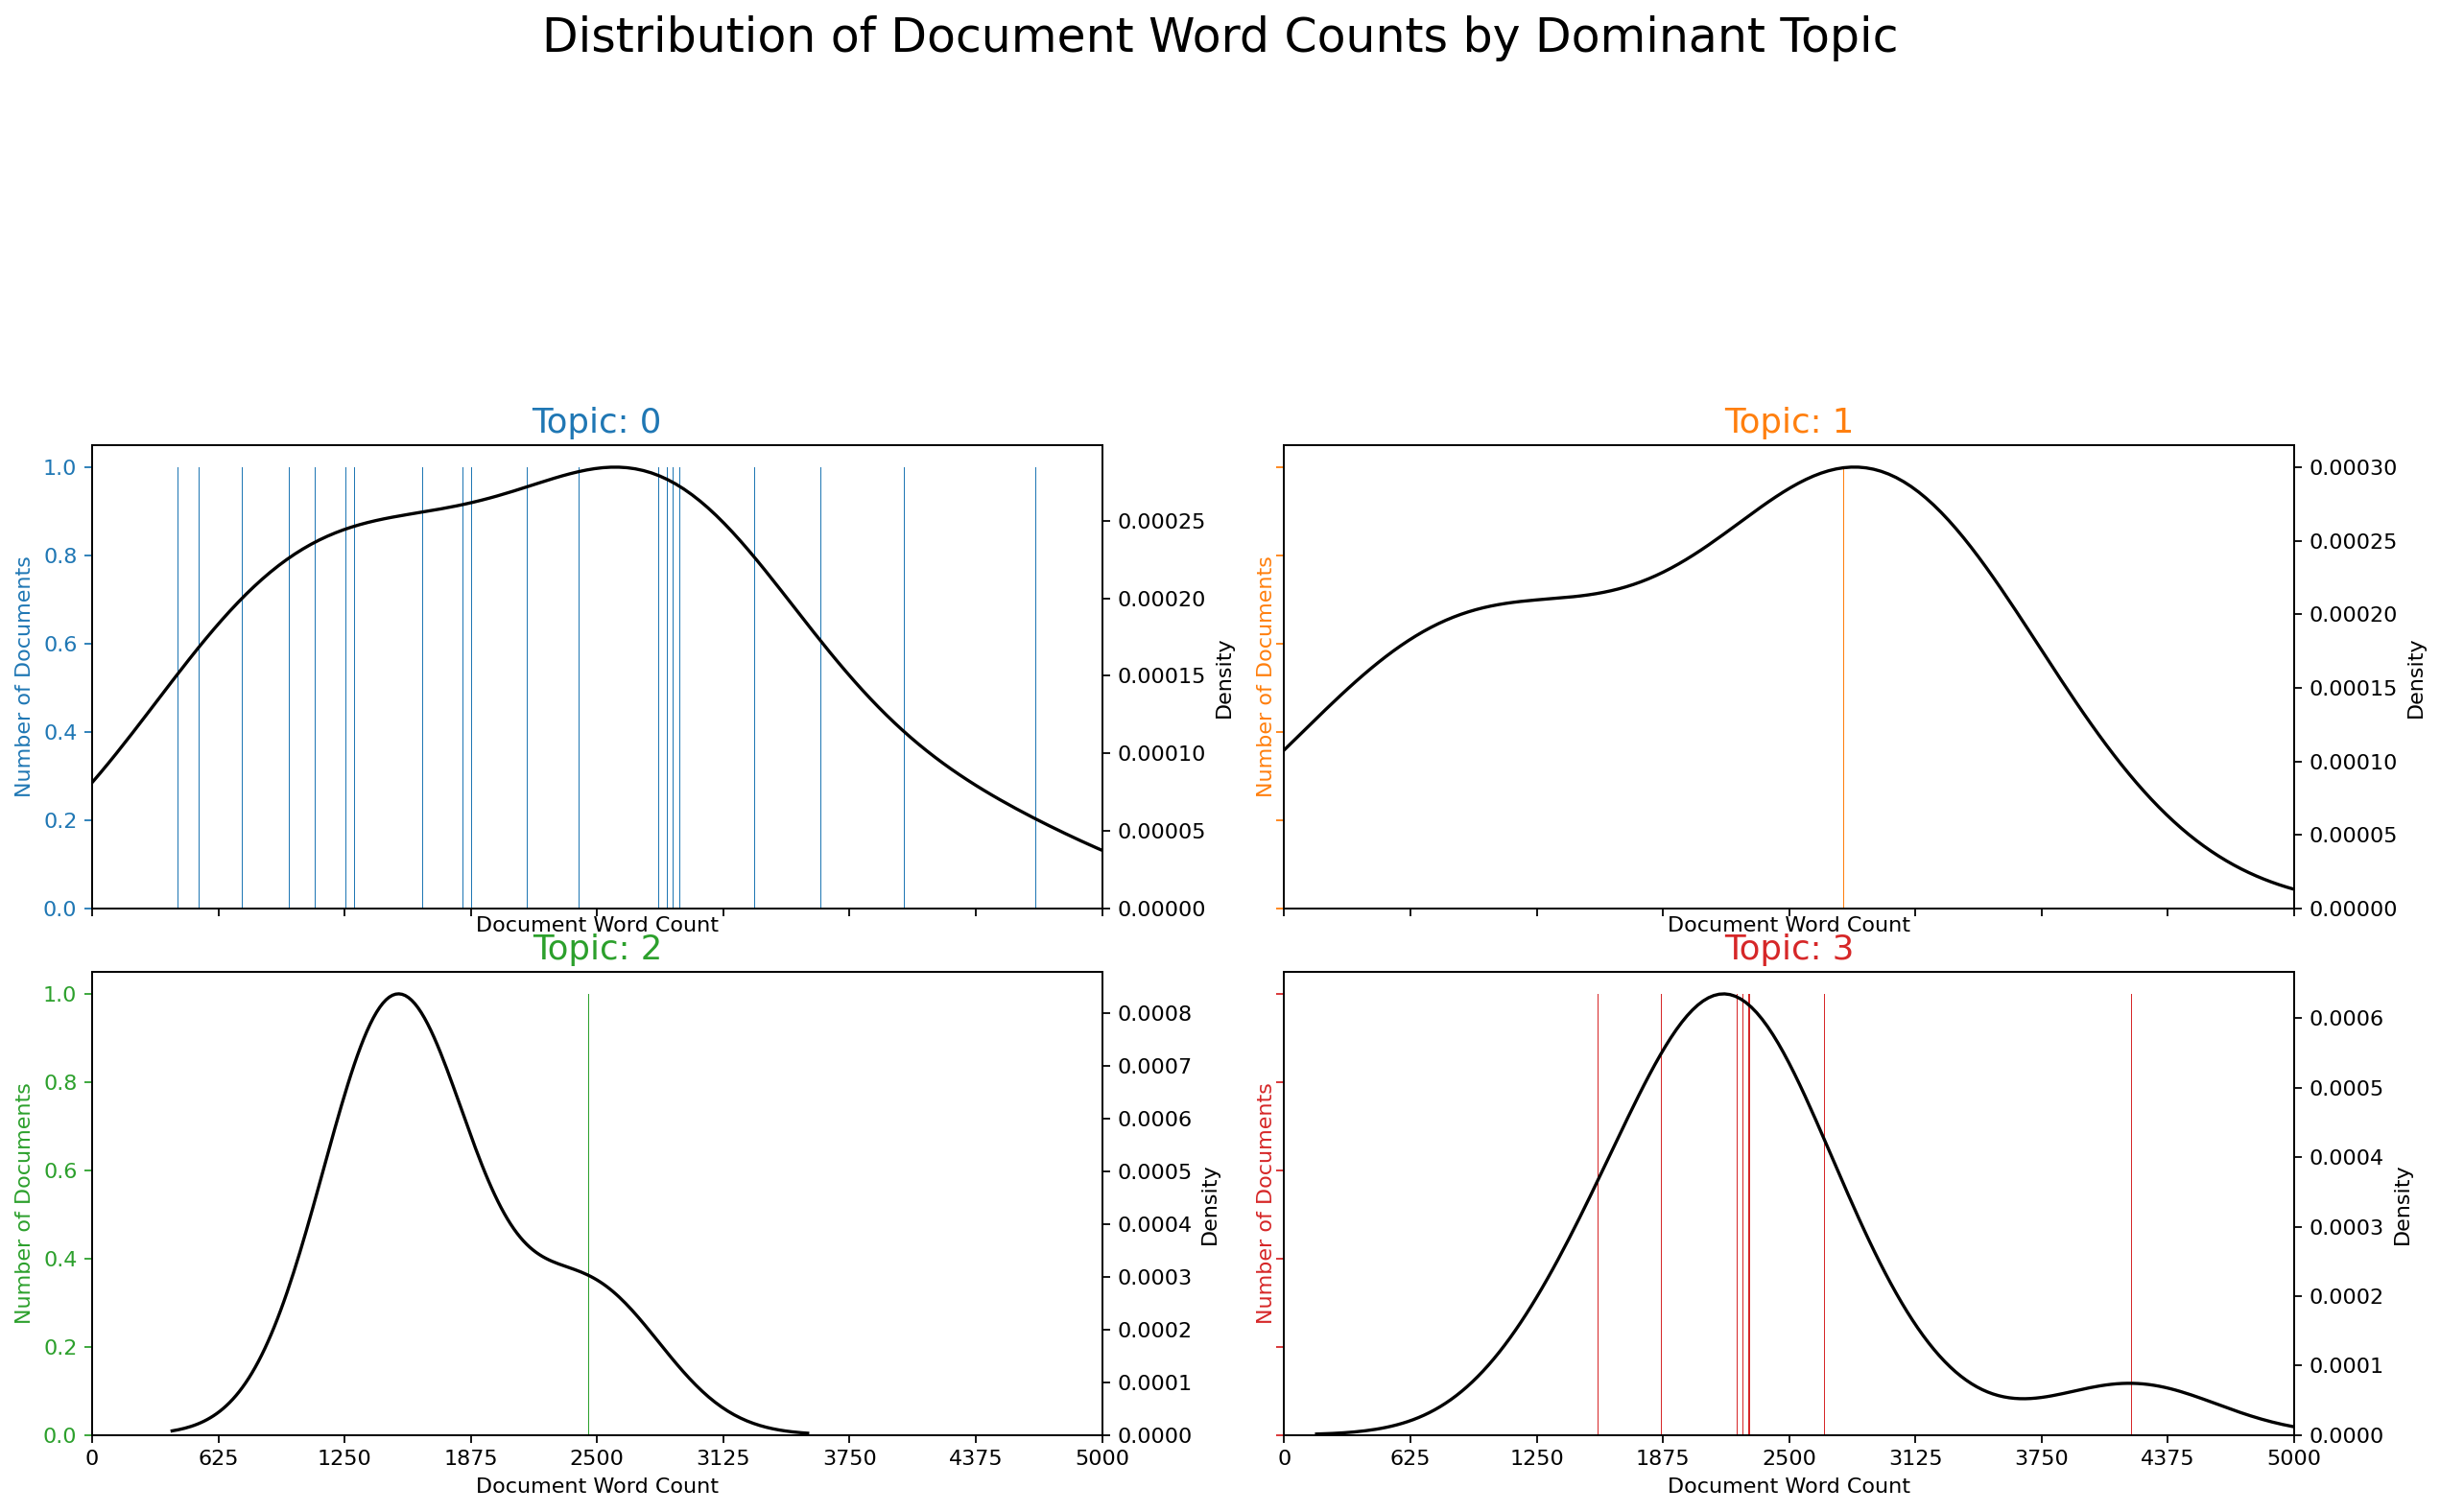

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,10), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 5000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.70)
plt.xticks(np.linspace(0,5000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

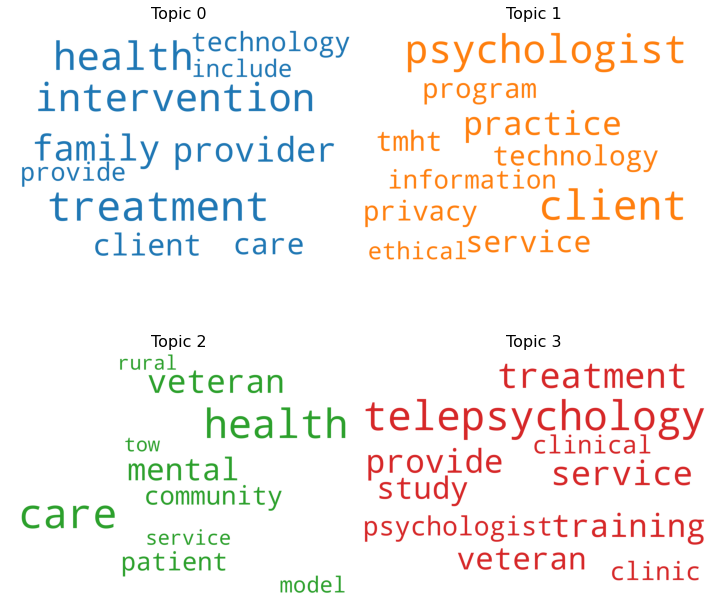

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

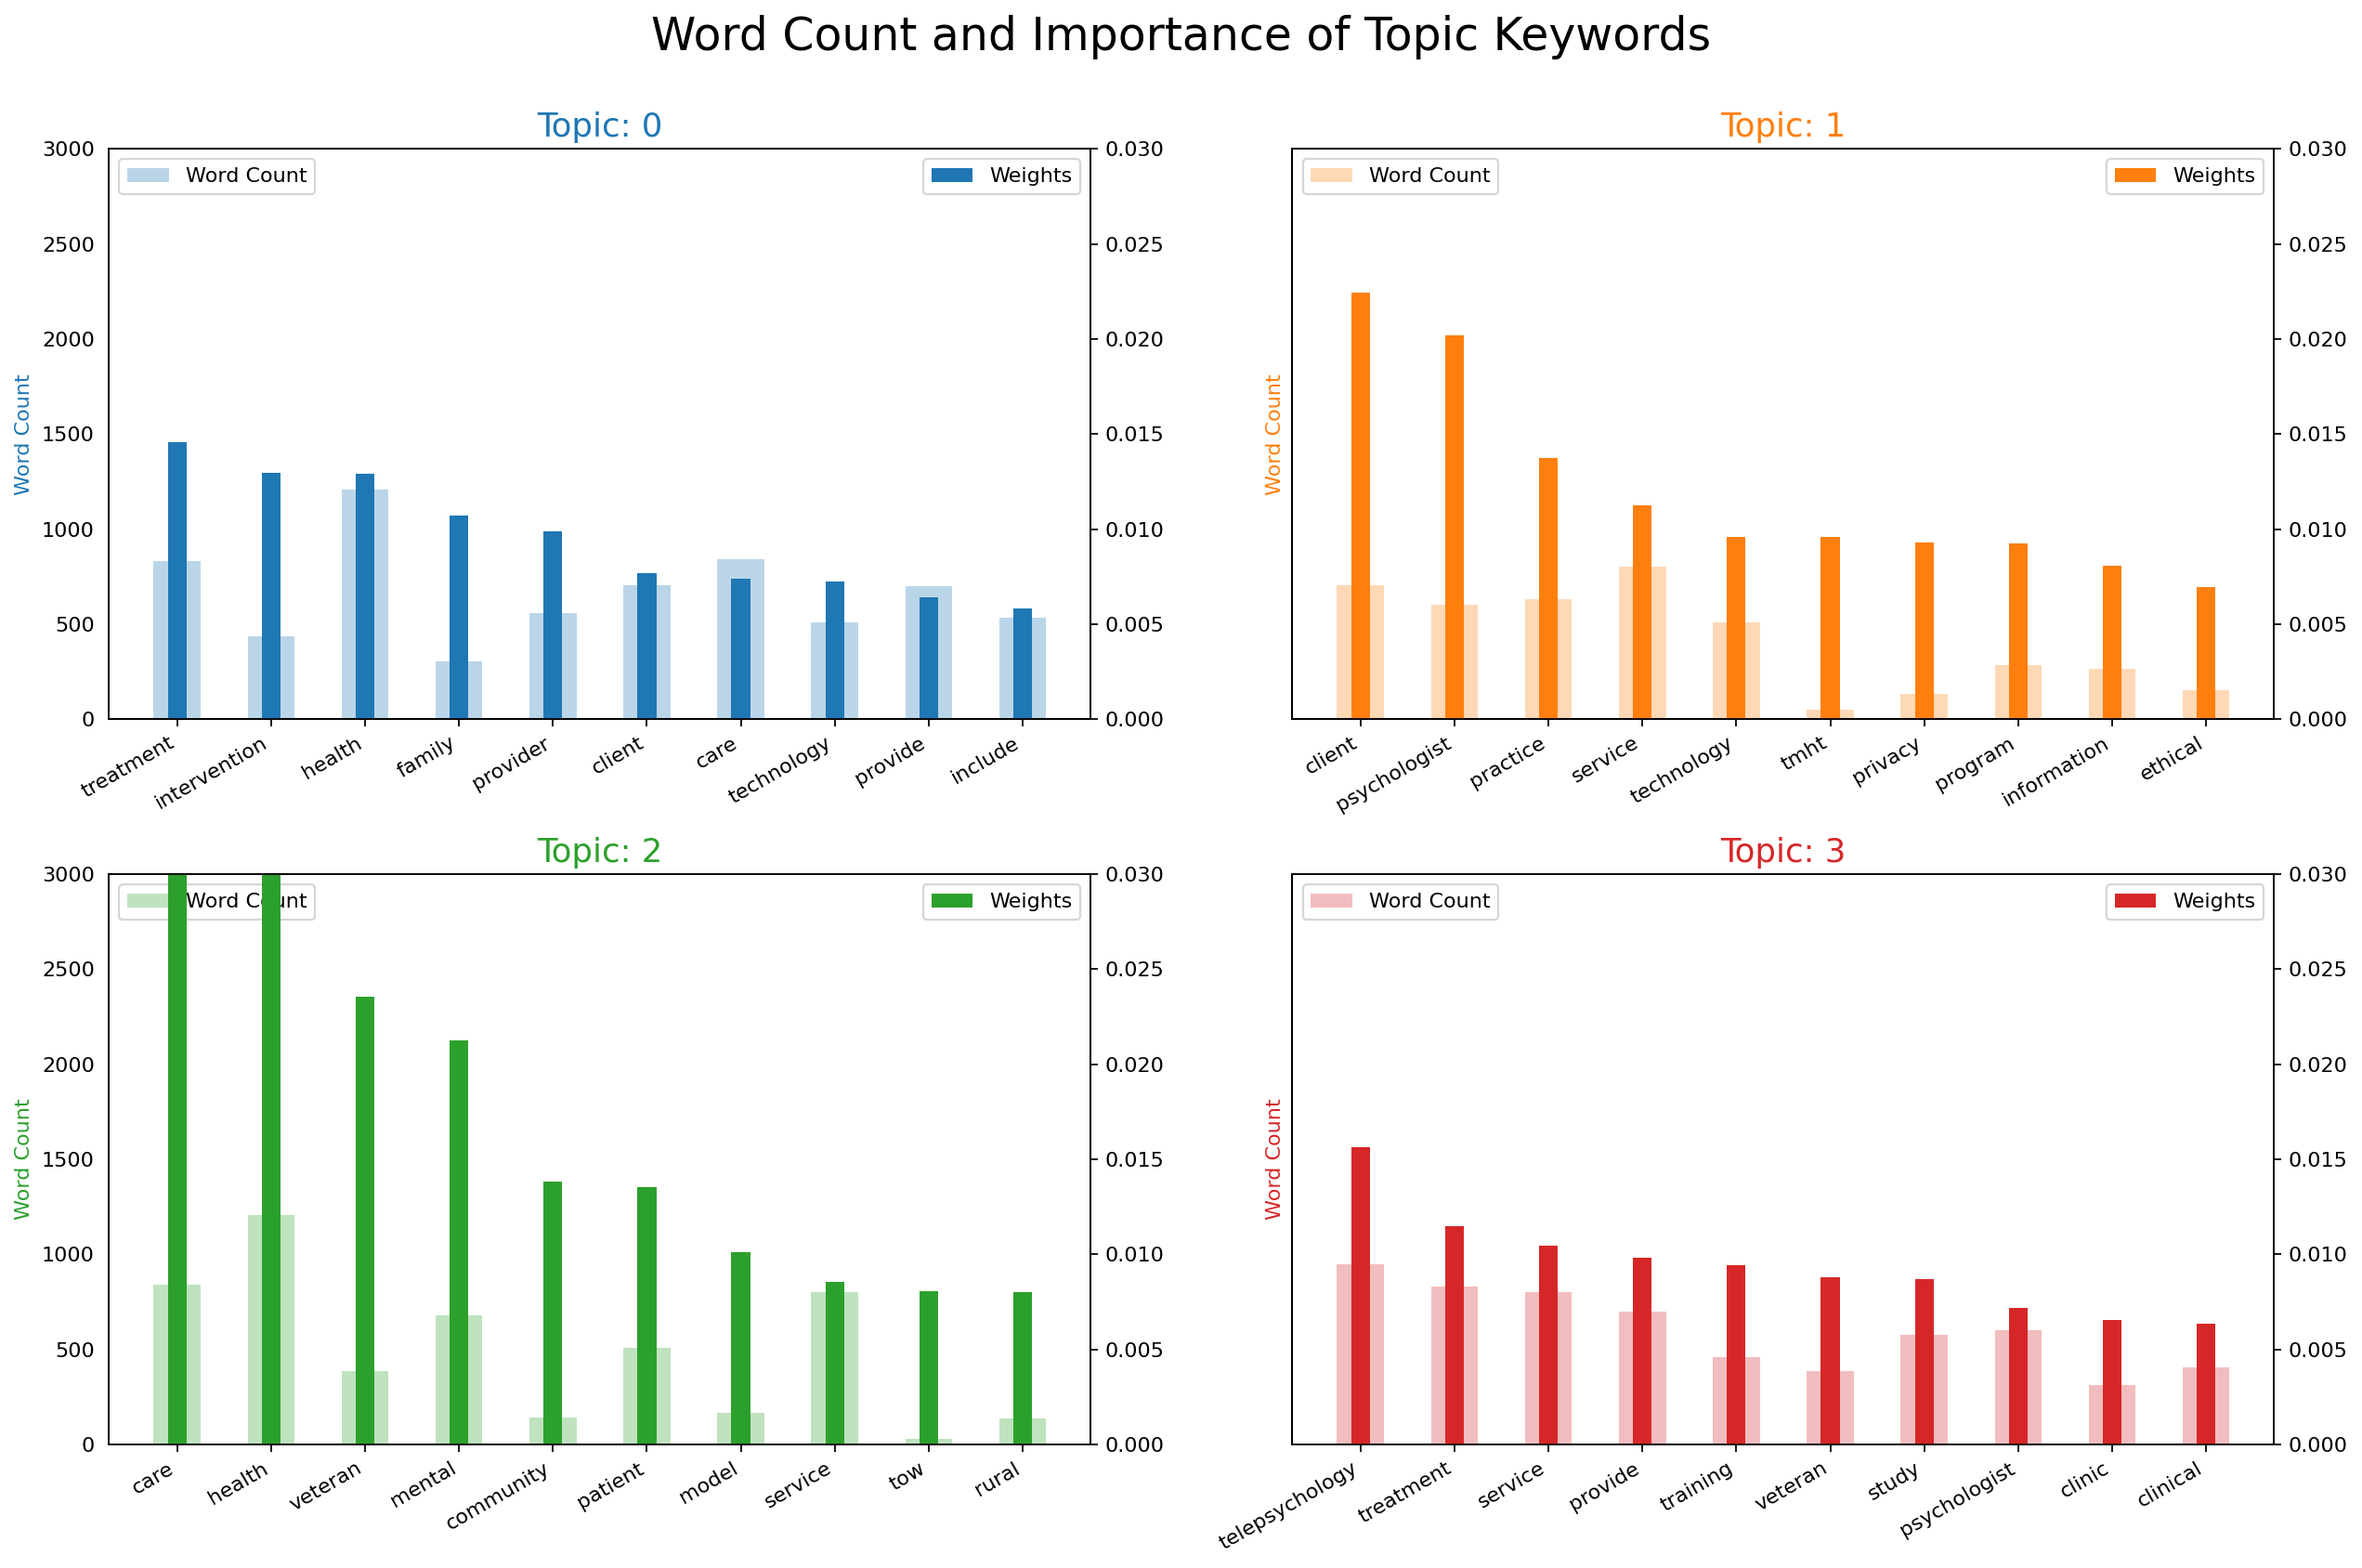

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic

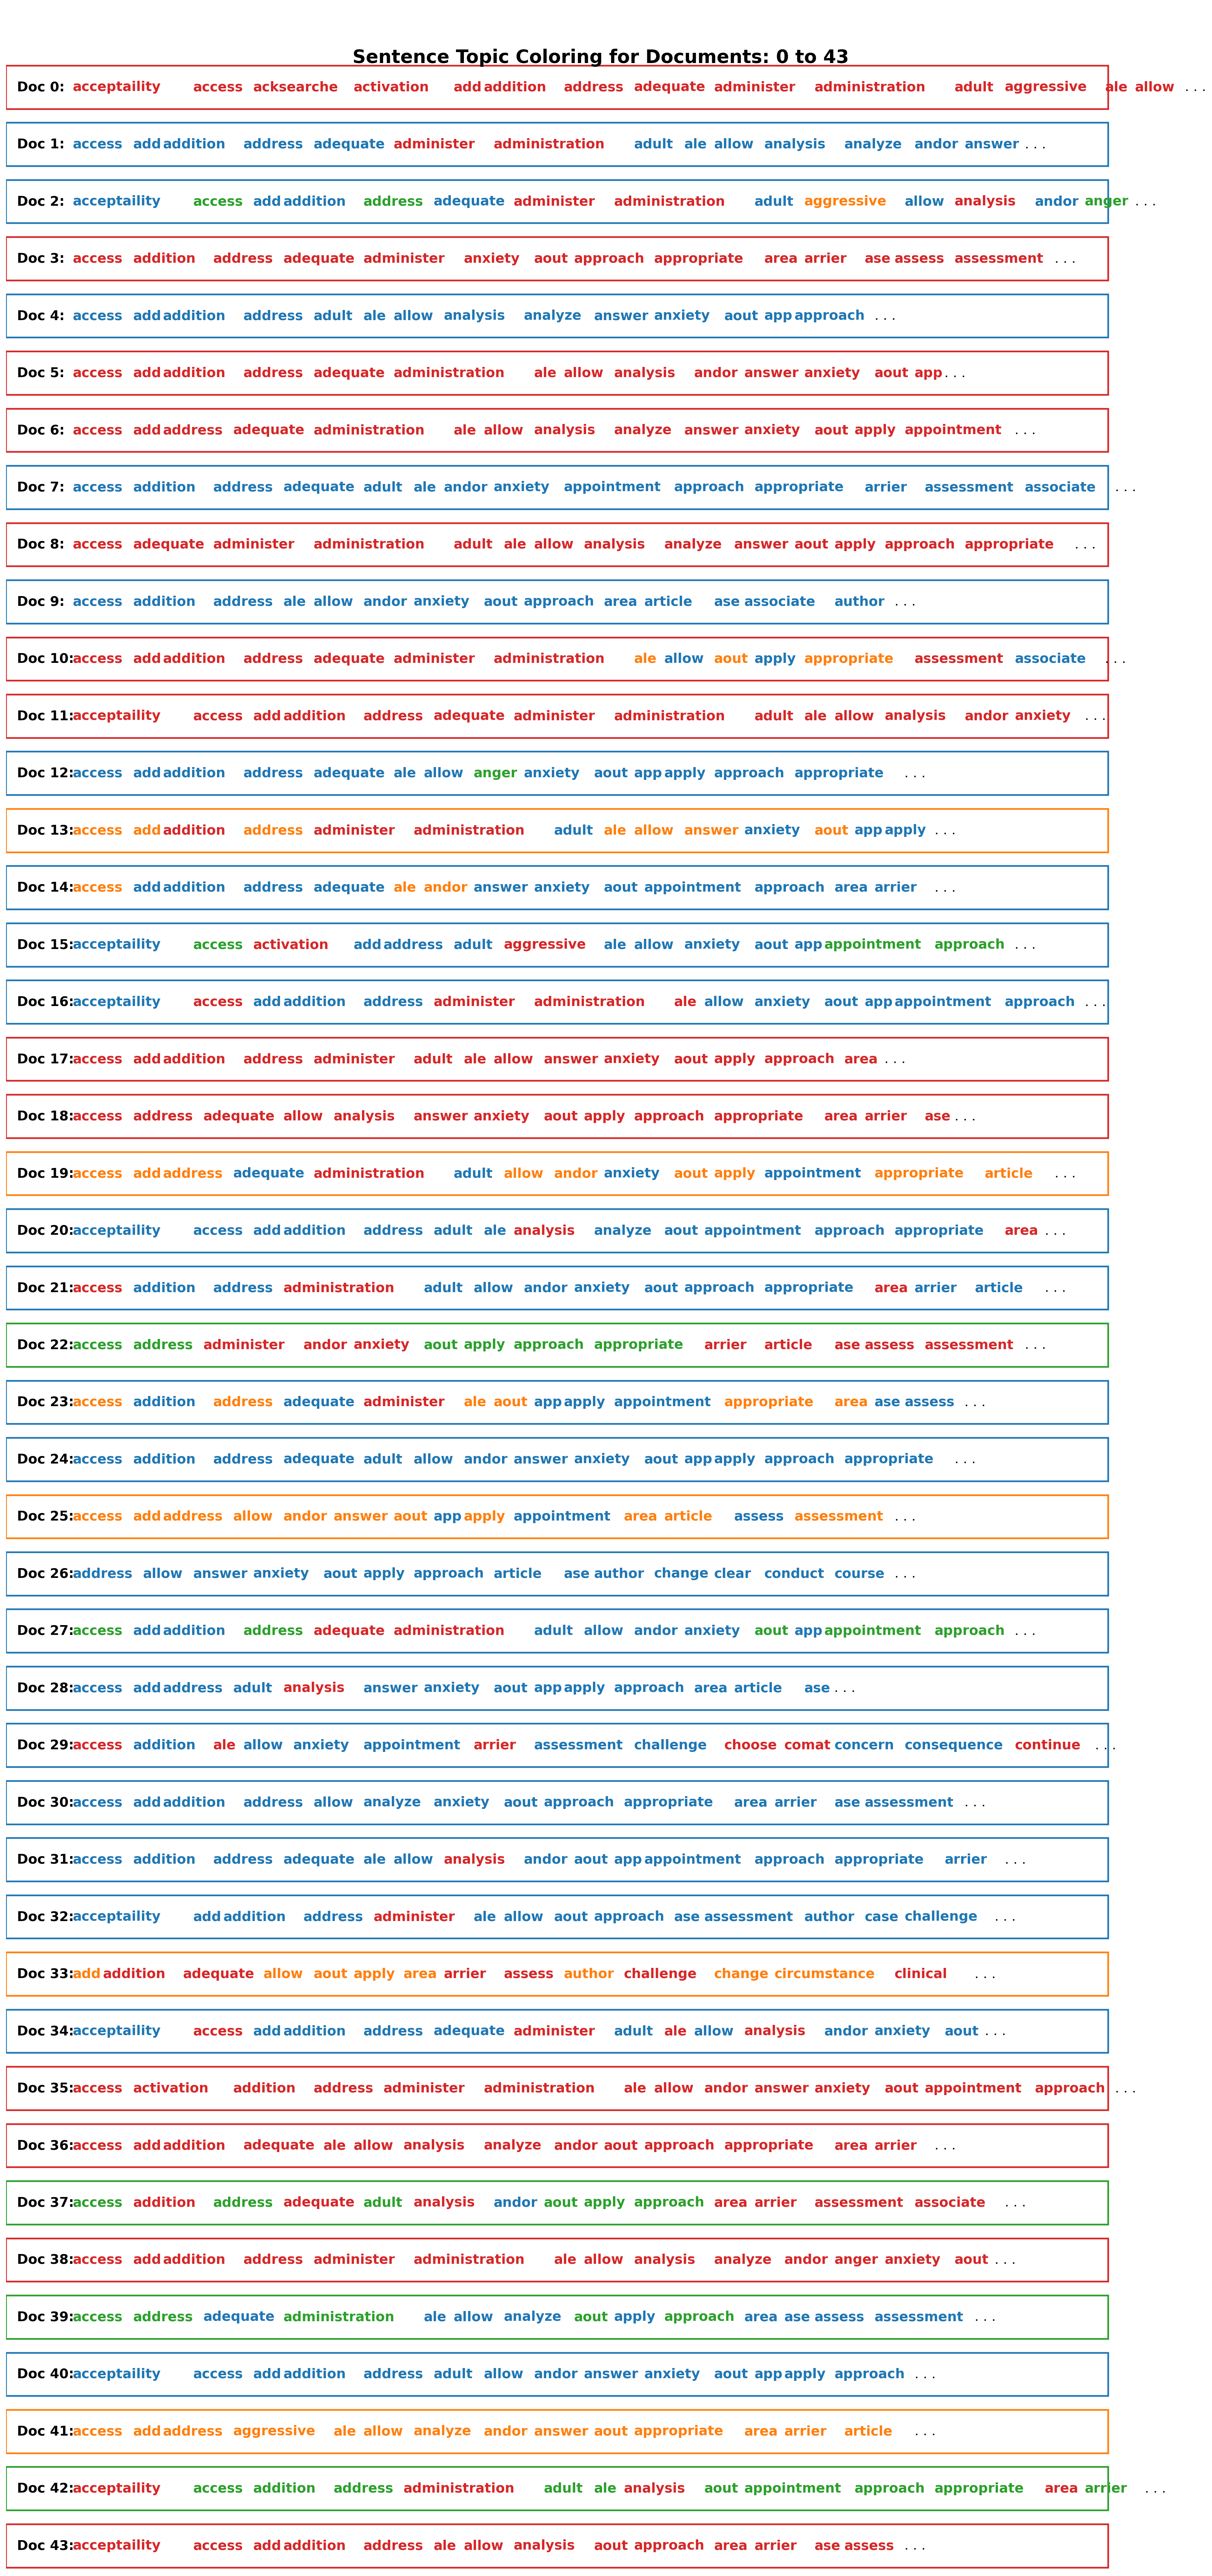

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 45):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.98, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

### What are the most discussed topics in the documents?

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 5]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

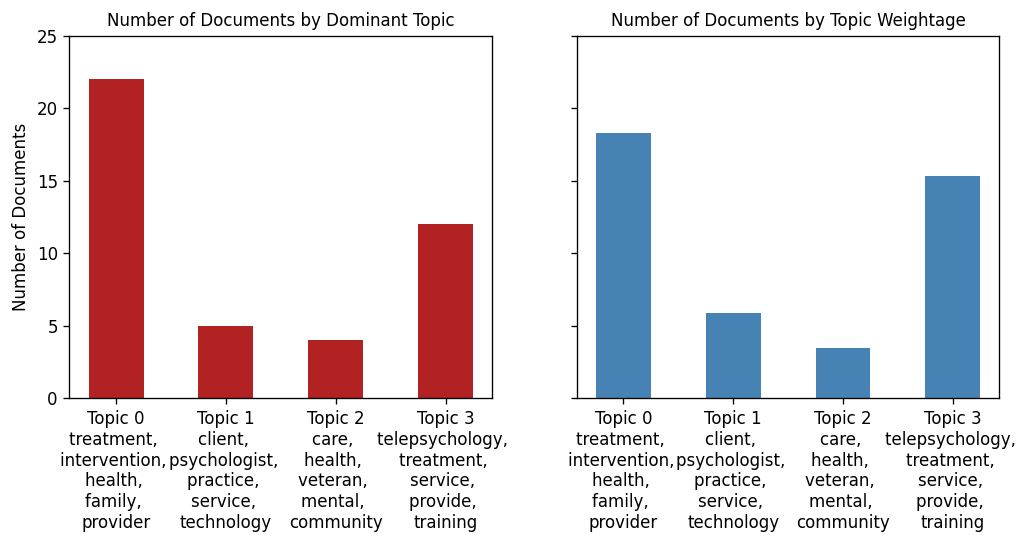

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 25)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 44 samples in 0.000s...
[t-SNE] Computed neighbors for 44 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 44 / 44
[t-SNE] Mean sigma: 0.562253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.710888
[t-SNE] KL divergence after 1000 iterations: 0.188652


### pyLDAVis

In [ ]:
!pip install pyLDAvis==2.1.2)
!pip install pyldavis

/bin/bash: -c: line 0: syntax error near unexpected token `)'
/bin/bash: -c: line 0: `pip install pyLDAvis==2.1.2)'
     |████████████████████████████████| 1.7MB 13.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 348kB/s 
     |████████████████████████████████| 9.9MB 34.1MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=b7b2c1fedbfc536c86a705476b2335200523961da609554c5b30c7192cd1af62
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyldavis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascie

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis
# feed the LDA model into the pyLDAvis instance
#lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.039202 -0.089822       1        1  41.094705
3     -0.030032 -0.109736       2        1  37.916081
1     -0.148610  0.137232       3        1  13.318981
2      0.217844  0.062326       4        1   7.670233, topic_info=              Term         Freq        Total Category  logprob  loglift
741           care   828.000000   828.000000  Default  30.0000  30.0000
236         health  1053.000000  1053.000000  Default  29.0000  29.0000
604        veteran   496.000000   496.000000  Default  28.0000  28.0000
768         client   636.000000   636.000000  Default  27.0000  27.0000
1419  psychologist   521.000000   521.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1685         video    28.003246   164.461542   Topic4  -5.5750   0.7975
263     individual    29.273071   284.202871   Topic4  -5.5306   0.2948
535        support    28.351245   301.064645   Topic4  -5.5626   0.2052
409       provider    28.307025   584.715806   Topic4  -5.5642  -0.4602
238           help    25.639359   151.710641   Topic4  -5.6632   0.7900

[314 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         1  0.223901      access
1         2  0.482697      access
1         3  0.189008      access
1         4  0.101773      access
8         1  0.047574  administer
...     ...       ...         ...
2367      4  0.728100        wide
625       1  0.570249        work
625       2  0.390582        work
625       3  0.015623        work
625       4  0.023435        work

[519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])